In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
project_path = "/content/drive/MyDrive/hair_segmentation"
os.chdir(project_path)
!pwd

Mounted at /content/drive
/content/drive/MyDrive/hair_segmentation


In [ ]:
!pip install albumentations
!pip install tensorflowjs

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, DepthwiseConv2D, ReLU, Add, Activation, BatchNormalization, SeparableConv2D, UpSampling2D, Lambda, Concatenate, Multiply
from tensorflow.keras.activations import relu
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import albumentations as A

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [ ]:
INPUT_SIZE = 256

x_train_dir = os.path.join(project_path, 'train_imgs')
y_train_dir = os.path.join(project_path, 'train_masks')

x_valid_dir = os.path.join(project_path, 'validation_imgs')
y_valid_dir = os.path.join(project_path, 'validation_masks')

In [ ]:
"""
Implement the portrait segmentation network by prisma
https://blog.prismalabs.ai/real-time-portrait-segmentation-on-smartphones-39c84f1b9e66
Author: yuhua cheng
Date: 11 June 2019
"""

def  _conv(inputs, filters, kernel, strides):
    x = Conv2D(filters, kernel, padding='same', strides=strides)(inputs)
    x = ReLU(max_value=6)(x)
    return x

def _conv_bn(inputs, filters, kernel, strides):
    """convolution block with batch normalization"""
    x = Conv2D(filters, kernel, padding='same', strides=strides)(inputs)
    x = BatchNormalization(axis=-1)(x)
    x = ReLU(max_value=6)(x)
    return x

def _sep_conv_bn(inputs, filters, kernel, strides, depth_activation=False):
    # depthwise
    x = DepthwiseConv2D(kernel, strides=strides, padding='same')(inputs)
    x = BatchNormalization(axis=-1)(x)
    x = ReLU(max_value=6)(x)
    # pointwise
    x = Conv2D(filters, (1,1),  strides=1, padding='same')(x)
    x = BatchNormalization(axis=-1)(x)
    x = ReLU(max_value=6)(x)
    return x

def _residual_block(inputs, filters, kernel, strides, n):
    """Residual block
    """
    x = inputs
    for i in range(n):
        x0 = x
        x = SeparableConv2D(filters, kernel, strides=strides, padding='same')(x)
        x = BatchNormalization(axis=-1)(x)
        x = ReLU(max_value=6)(x)
        X = SeparableConv2D(filters, kernel, strides=strides, padding='same')(x)
        x = BatchNormalization(axis=-1)(x)
        x = ReLU(max_value=6)(x)
        x = Add()([x, x0])
    return x
    
def _deconv_block(inputs, filters, kernel, strides):
    x = Conv2DTranspose(filters=filters, kernel_size=kernel, strides=strides, padding='same')(inputs)
    x = BatchNormalization(axis=-1)(x)
    x = ReLU(max_value=6)(x)
    return x

def PrismaMattingNet(input_shape=(224,224,3), n_classes=1):
    inputs = Input(shape=input_shape)
    x = _conv_bn(inputs, 16, (3,3), 1)
    x = _residual_block(x, 16, (3,3), 1, 1) 
    
    b1 = _conv_bn(x, 32, (3,3), 2)
    b1 = _residual_block(b1, 32, (3,3), 1, 1)

    b2 = _conv_bn(b1, 64, (3,3), 2)
    b2 = _residual_block(b2, 64, (3,3), 1, 1)

    b3 = _conv_bn(b2, 128, (3,3), 2)
    b3 = _residual_block(b3, 128, (3,3), 1, 2)

    b4 = _conv_bn(b3, 128, (3,3), 2)
    b4 = _residual_block(b4, 128, (3,3), 1, 6)


    up1 = UpSampling2D(size=(2,2), interpolation='bilinear')(b4)
    up1 = Add()([up1, b3])
    up1 = _conv_bn(up1, 64, (3,3), 1)
    up1 = _residual_block(up1, 64, (3,3), 1, 3, )    
    
    up2 = UpSampling2D(size=(2,2), interpolation='bilinear')(up1)
    up2 = Add()([up2, b2])
    up2 = _conv_bn(up2, 32, (3,3), 1)
    up2 = _residual_block(up2, 32, (3,3), 1, 3)

    up3 = UpSampling2D(size=(2,2), interpolation='bilinear')(up2)
    up3 = Add()([up3, b1])
    up3 = _conv_bn(up3, 16, (3,3), 1)
    up3 = _residual_block(up3, 16, (3, 3), 1, 3)

    up4 = UpSampling2D(size=(2,2), interpolation='bilinear')(up3)
    up4 = Add()([up4, x])
    up4 = _conv_bn(up4, 8, (3,3), 1)
    up4 = _residual_block(up4, 8, (3,3), 1, 3)

    output = Conv2D(n_classes, (1,1), padding='same', name='softmax_conv')(up4)
    
    if n_classes == 1:
        output = Activation('sigmoid')(output)
    else:
        output = Activation('softmax')(output)

    model = Model(inputs, output)
    return model

model = PrismaMattingNet((INPUT_SIZE, INPUT_SIZE, 3))
# model.summary()

In [ ]:
# Data augmentation
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

def get_train_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
        A.RandomCrop(height=INPUT_SIZE, width=INPUT_SIZE, always_apply=True),
        A.Perspective(p=0.5),

        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)

# helper function for data visualization
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(10, 5))
    for i, (name, image) in enumerate(images.items()):
        print(f'{name} shape: {image.shape}')
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(name.title())
        plt.imshow(image)
    plt.show()

# classe for data loading and preprocessing
class Dataset:
    
    def __init__(
            self, 
            images_dir, 
            masks_dir,
            augment=False
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id.replace('png', 'bmp')) for image_id in self.ids]

        self.augmentation = get_train_augmentation() if augment == True else None

    def __getitem__(self, i):

        image = cv2.imread(self.images_fps[i])
        mask = cv2.imread(self.masks_fps[i])

        if image is None or mask is None:
            return None

        image = cv2.resize(image, (INPUT_SIZE, INPUT_SIZE))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

        mask = cv2.resize(mask, (INPUT_SIZE, INPUT_SIZE))
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = np.expand_dims(mask, axis=2)
        mask = cv2.normalize(mask, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

        hair_mask = np.zeros_like(mask)
        hair_mask[mask == 1.0] = 1.0

        if self.augmentation:
            sample = self.augmentation(image=image, mask=hair_mask)
            image, hair_mask = sample['image'], sample['mask']

        return image, hair_mask
        
    def __len__(self):
        return len(self.ids)

image shape: (256, 256, 3)
mask shape: (256, 256)


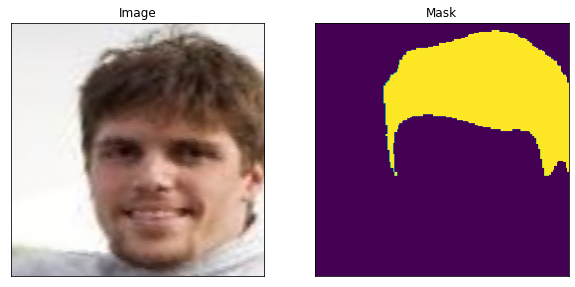

In [ ]:
dataset = Dataset(x_train_dir, y_train_dir, True)
image, mask = dataset[0]
visualize(image=image, mask=mask)

In [ ]:
class DataLoader(Sequence):
    
    def __init__(self, dataset, batch_size=16, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch_img = []
        batch_mask = []
        for image, mask in data:
            batch_img.append(image)
            batch_mask.append(mask)

        batch = [np.stack(batch_img, axis=0), np.stack(batch_mask, axis=0)]

        return batch
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [ ]:
# Hyper parameters
EPOCHS = 15
LR = 0.0005


# Losses and Metrics
def dice_coef(y_true, y_pred):
    smooth=1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_coef_loss(y_true, y_pred):
    dice = dice_coef(y_true, y_pred)
    return 1 - dice

def precision(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    true_positives = K.sum(K.round(K.clip(y_true_f * y_pred_f, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred_f, 0, 1)))

    return true_positives / (predicted_positives + K.epsilon())

def recall(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    true_positives = K.sum(K.round(K.clip(y_true_f * y_pred_f, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true_f, 0, 1)))

    return true_positives / (possible_positives + K.epsilon())


# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    mode='min',
    verbose=1,
    patience=2)

model_save = ModelCheckpoint(
    './prism_model_v2.h5',
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="min")

def create_lr_schedule(epochs, lr_base, lr_power=0.99):
    return lambda epoch: _lr_schedule(epoch, epochs, lr_base, lr_power)

def _lr_schedule(epoch, epochs, lr_base, lr_power):
    lr = lr_base * ((1 - float(epoch) / epochs) ** lr_power)
    print('LR: %f' % lr)
    return lr

learning_rate_scheduler = LearningRateScheduler(create_lr_schedule(EPOCHS, lr_base=LR))

In [ ]:
model = PrismaMattingNet((INPUT_SIZE, INPUT_SIZE, 3))
model.compile(
        optimizer=Adam(learning_rate=LR),
        loss=dice_coef_loss,
        metrics=[
            dice_coef,
            'binary_crossentropy',
            precision,
            recall
        ],
    )

train_ds = Dataset(x_train_dir, y_train_dir, True)
valid_ds = Dataset(x_valid_dir, y_valid_dir)

train_dl = DataLoader(train_ds)
valid_dl = DataLoader(valid_ds)

In [ ]:
history = model.fit(
    train_dl,
    steps_per_epoch=len(train_dl),
    epochs=EPOCHS,
    validation_data=valid_dl,
    validation_steps=len(valid_dl),
    callbacks=[early_stop, model_save, learning_rate_scheduler],
)

In [ ]:
# Plot training loss
plt.figure(figsize=(20, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model.load_weights('prism_model_v2.h5')

1/1 [==============================] - 4s 4s/step


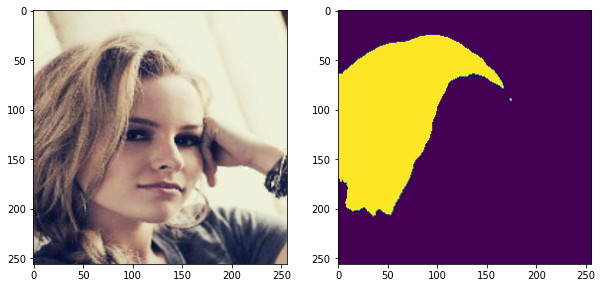

In [ ]:
image, mask = valid_ds[4]
image = np.expand_dims(image, axis=0)
pred = model.predict(image).round()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image.squeeze())

plt.subplot(1, 2, 2)
plt.imshow(pred.squeeze())
plt.show()

In [ ]:
# !pip install tensorflowjs

import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, './models/prism_model_v2')